# Анализ выгрузки финансов

Эта тетрадка сделана, чтобы разрабатывать и тестировать функции бота

## Загрузка данных

In [242]:
# импорт библиотек
# работа с данными
import numpy as np
import pandas as pd

# графика
from matplotlib import pyplot as plt
from matplotlib import ticker

# метрика
from sklearn.metrics import mean_squared_error

# работа с нейронными сетями
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

# полоса загрузки
from tqdm import tqdm

In [243]:
# чтение csv
df = pd.read_csv('fin.csv', sep=';')

## Предобработка данных

In [244]:
# обзор данных
df.head()

,Дата операции,Дата платежа,Номер карты,Статус,Сумма операции,Валюта операции,Сумма платежа,Валюта платежа,Кэшбэк,Категория,MCC,Описание,Бонусы (включая кэшбэк),Округление на инвесткопилку,Сумма операции с округлением
0,14.03.2025 12:21:06,14.03.2025,*7267,OK,"-700,00",RUB,"-700,00",RUB,7.0,Красота,7230.0,Супермен,"7,00","0,00","700,00"
1,13.03.2025 18:16:07,13.03.2025,*7267,OK,"-964,93",RUB,"-964,93",RUB,9.0,Супермаркеты,5411.0,Пятёрочка,"9,00","0,00","964,93"
2,13.03.2025 11:41:04,13.03.2025,*7267,OK,"-579,94",RUB,"-579,94",RUB,5.0,Супермаркеты,5411.0,Магнит,"5,00","0,00","579,94"
3,13.03.2025 11:22:16,13.03.2025,*7267,OK,"-94,90",RUB,"-94,90",RUB,NaN,Супермаркеты,5411.0,SPAR,"0,00","0,00","94,90"
4,12.03.2025 22:16:04,13.03.2025,*7267,OK,"-906,00",RUB,"-906,00",RUB,45.0,Такси,4121.0,Яндекс Такси,"45,00","0,00","906,00"


In [245]:
# удаление лишних данных
df = df[['Дата операции', 'Сумма операции', 'Категория', 'Описание']]
#df.head()

In [246]:
# анализ типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Дата операции   3085 non-null   object
 1   Сумма операции  3085 non-null   object
 2   Категория       3070 non-null   object
 3   Описание        3085 non-null   object
dtypes: object(4)
memory usage: 96.5+ KB


In [247]:
# переименование столбцов
df.columns = ['dt', 'sum', 'category', 'description']
df.head()

,dt,sum,category,description
0,14.03.2025 12:21:06,"-700,00",Красота,Супермен
1,13.03.2025 18:16:07,"-964,93",Супермаркеты,Пятёрочка
2,13.03.2025 11:41:04,"-579,94",Супермаркеты,Магнит
3,13.03.2025 11:22:16,"-94,90",Супермаркеты,SPAR
4,12.03.2025 22:16:04,"-906,00",Такси,Яндекс Такси


In [248]:
# приведение типов
df['dt'] = pd.to_datetime(df['dt'], dayfirst=True)
df['sum'] = pd.to_numeric(df['sum'].str.replace(',', '.'))

In [249]:
# Установка индекса
df.index = df['dt']

In [250]:
# сортировка по индексу
df.sort_index(inplace=True)

In [251]:
# добавление столбца баланса
df['balance'] = df['sum'].cumsum()

In [252]:
# анализ содержимого
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
dt,3085,NaN,NaN,NaN,2023-07-24 21:53:07.212965888,2021-05-10 11:50:01,2022-04-03 14:37:54,2024-01-05 15:46:42,2024-08-27 22:58:10,2025-03-14 12:21:06,NaN
sum,3085.0,NaN,NaN,NaN,-95.432885,-700000.0,-686.83,-245.98,-79.0,770765.02,39463.587553
category,3070,43,Супермаркеты,755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,3085,439,Пятёрочка,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,3085.0,NaN,NaN,NaN,-193616.990347,-526091.92,-468017.56,-140962.57,23151.33,513737.06,259200.448202


## Исследовательский анализ

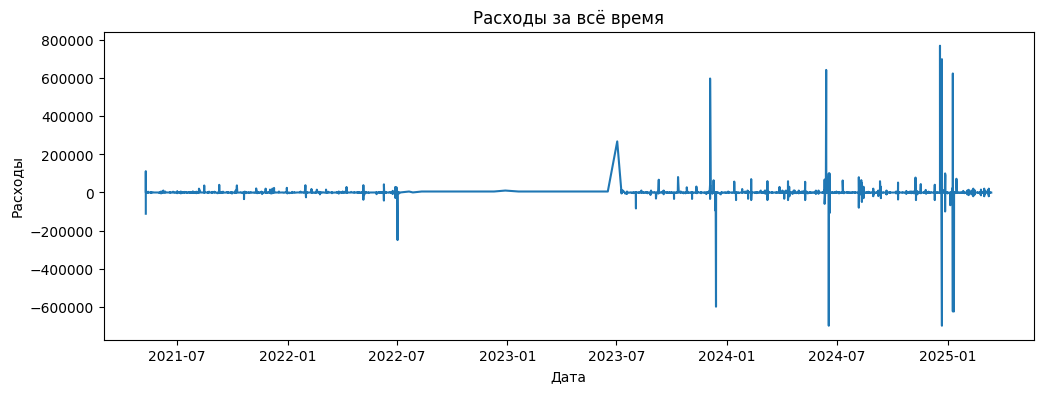

In [253]:
# график трат
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df['sum'])
ax.set_title('Расходы за всё время')
ax.set_xlabel('Дата')
ax.set_ylabel('Расходы')
plt.show()

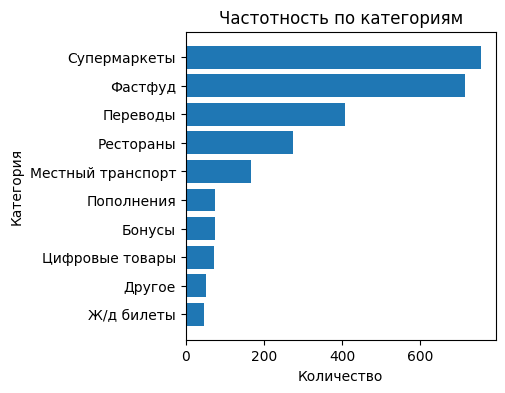

In [254]:
# диаграмма частотности трат по категориям
fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(df['category'].value_counts().sort_values(ascending=False).head(10).index, 
        df['category'].value_counts().sort_values(ascending=False).head(10))
ax.set_xlabel('Количество')
ax.set_ylabel('Категория')
ax.invert_yaxis()
ax.set_title('Частотность по категориям')
plt.show()

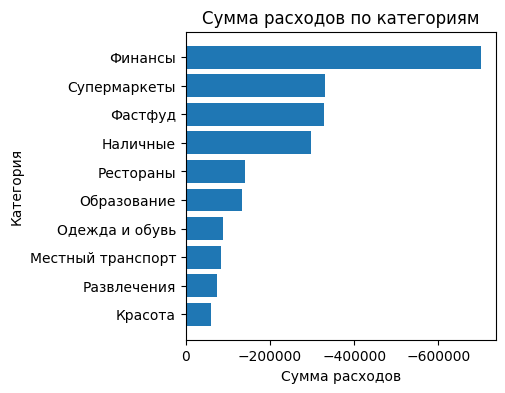

In [255]:
# диаграмма суммы трат по категориям
fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(df.pivot_table(index='category', values='sum', aggfunc='sum').sort_values(by='sum', ascending=True)['sum'].head(10).index, 
        df.pivot_table(index='category', values='sum', aggfunc='sum').sort_values(by='sum', ascending=True)['sum'].head(10))
ax.set_xlabel('Сумма расходов')
ax.set_ylabel('Категория')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Сумма расходов по категориям')
plt.show()

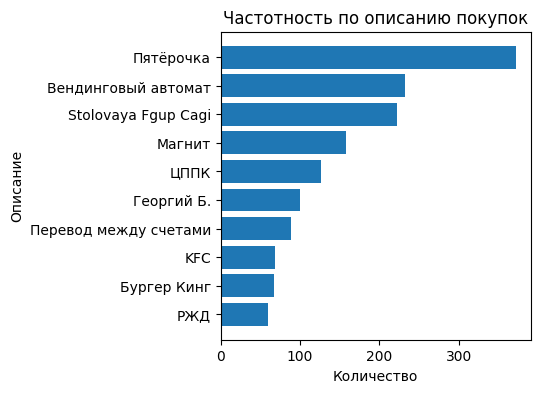

In [256]:
# диаграмма частотности трат по описанию
fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(df['description'].value_counts().sort_values(ascending=False).head(10).index, 
        df['description'].value_counts().sort_values(ascending=False).head(10))
ax.set_xlabel('Количество')
ax.set_ylabel('Описание')
ax.invert_yaxis()
ax.set_title('Частотность по описанию покупок')
plt.show()

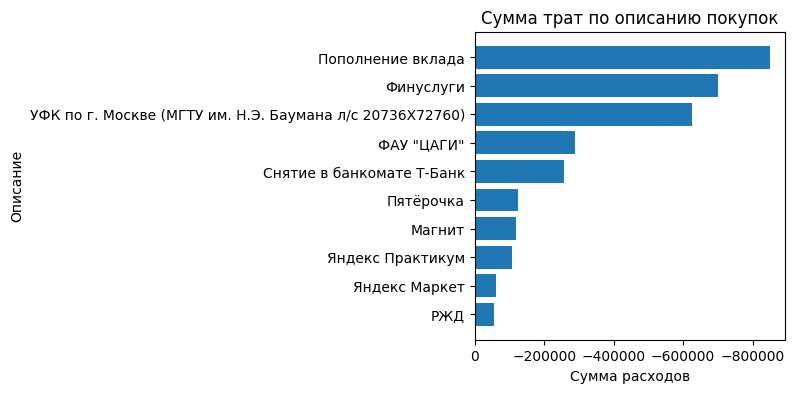

In [257]:
# диаграмма суммы трат по описанию
fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(df.pivot_table(index='description', values='sum', aggfunc='sum').sort_values(by='sum', ascending=True)['sum'].head(10).index, 
        df.pivot_table(index='description', values='sum', aggfunc='sum').sort_values(by='sum', ascending=True)['sum'].head(10))
ax.set_xlabel('Сумма расходов')
ax.set_ylabel('Описание')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Сумма трат по описанию покупок')
plt.show()

## Разработка функционала бота

**Функционал бота**
- Отображение баланса;
- Сравнение годовых изменений баланса;
- Сравнение месячных трат по категориям;
- Сравнение месячных трат по частоте;
- Оценка среднемесячных расходов;
- Прогноз времени опустошения бюджета.

In [258]:
# отображение баланса
def plot_balance(start_date, end_date):
    '''Функция принимает на вход 2 даты. Строит график баланса'''
    plt.figure(figsize=(12, 4))
    plt.plot(df.loc[start_date:end_date, 'balance'])
    plt.grid()
    plt.title('График баланса')
    plt.xlabel('Дата')
    plt.ylabel('Баланс')

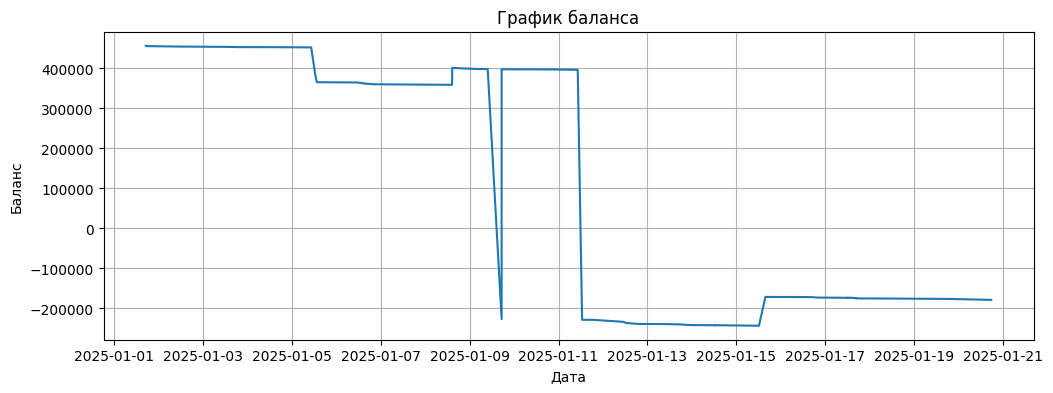

In [259]:
# проверка функции
plot_balance('2025-01-01', '2025-01-20')

In [260]:
# годовые изменения баланса
def plot_years():
    '''Функция строит график баланса за последние 3 года'''
    # определение последнего года в данных
    last_year = df.index.max().year

    # построение графиков баланса
    fig, ax = plt.subplots(nrows=3, figsize=(16, 10))
    fig.suptitle('Баланс за последние 3 года')
    fig.subplots_adjust(hspace=0.5)

    for i in range(3):
        year = str(last_year - i)
        df.loc[year + '-01-01':year +'-12-31', 'balance'].plot(ax=ax[i])
        
        xticks = ticker.MaxNLocator(12)
        yticks = ticker.MaxNLocator(10)
        ax[i].xaxis.set_major_locator(xticks)
        ax[i].yaxis.set_major_locator(yticks)

        ax[i].grid()
        ax[i].tick_params(labelrotation=0)
        ax[i].set_title(year + ' год')
        ax[i].set_xlabel('Дата')
        ax[i].set_ylabel('Баланс')

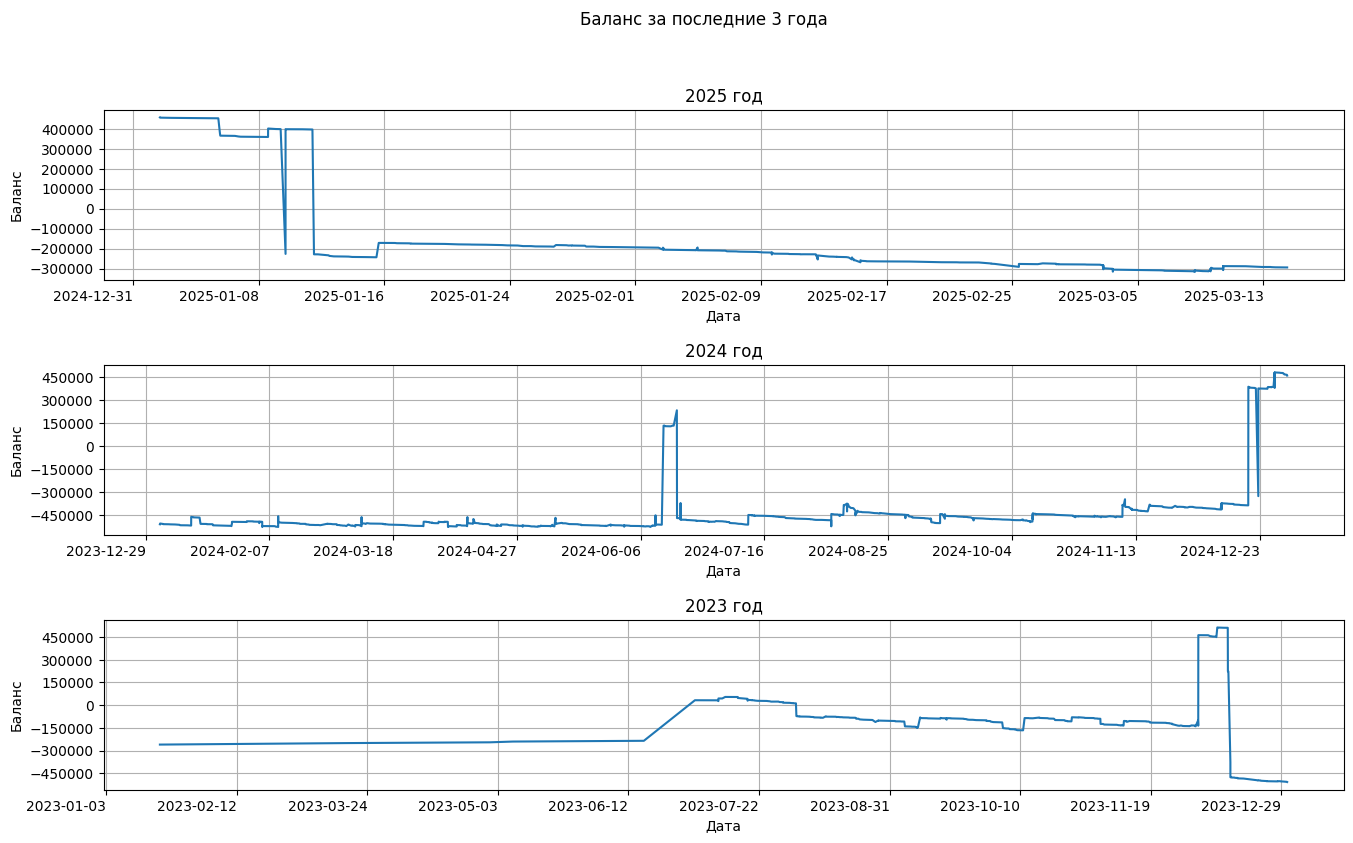

In [261]:
# проверка функции
plot_years()

In [262]:
# месячные траты по категориям
def plot_scats(month, year):
    '''Функция принимает на вход месяц и год. Выводит диаграмму трат по категориям.'''
    # формирование датафрейма месяца
    month_data = df.loc[str(year) + '-' + str(month)]
    month_pivot = month_data.pivot_table(index='category', values='sum', aggfunc='sum')\
        .sort_values(by='sum', ascending=True)['sum']

    # построение графиков
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.barh(month_pivot.index, 
            month_pivot)
    ax.grid()
    ax.set_xlabel('Сумма расходов')
    ax.set_ylabel('Категория')
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_title('Сумма расходов по категориям')
    plt.show()

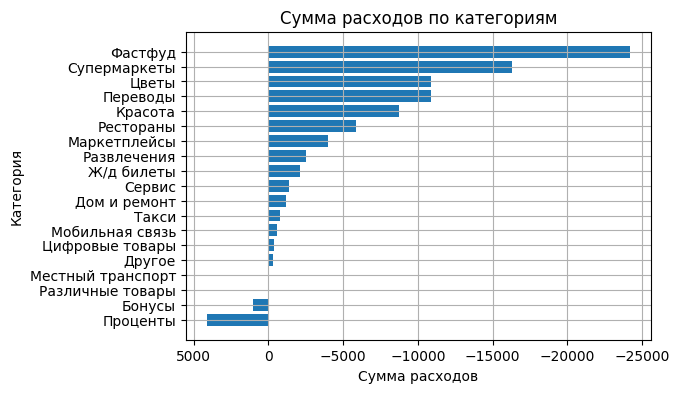

In [263]:
# проверка функции
plot_scats(2, 2025)

In [264]:
# месячные траты по частоте
def plot_rcats(month, year):
    '''Функция принимает на вход месяц и год. Выводит диаграмму трат по частоте.'''
    # формирование датафрейма месяца
    month_data = df.loc[str(year) + '-' + str(month)]
    month_pivot = month_data.pivot_table(index='category', values='sum', aggfunc='count')\
        .sort_values(by='sum', ascending=False)['sum']

    # построение графиков
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.barh(month_pivot.index, 
            month_pivot,
            color='orange')
    ax.grid()
    ax.set_xlabel('Частота расходов')
    ax.set_ylabel('Категория')
    ax.invert_yaxis()
    ax.set_title('Частота расходов по категориям')
    plt.show()

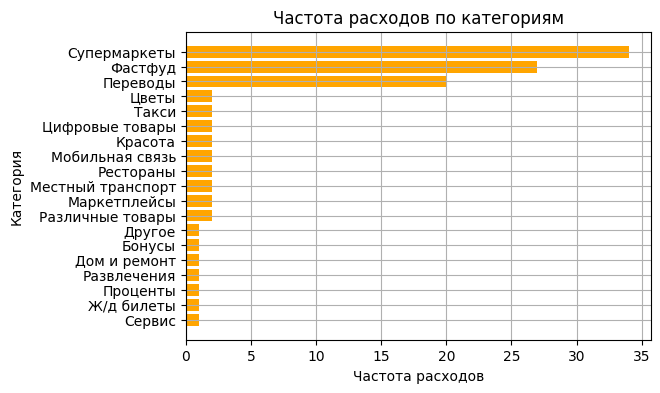

In [265]:
# проверка функции
plot_rcats(2, 2025)

In [266]:
# расчет времени опустошения бюджета
def balance_count():
    '''Функция возвращает количество месяцев, которое можно прожить на текущий баланс.'''
    # определение текущего баланса
    balance = np.abs(df.iloc[-1]['balance'])

    # определение среднемесячных трат
    avg_month = np.abs(df['2023-01-01': '2024-12-31']['sum'].resample('ME').sum().mean())

    # вывод количества месяцев
    print(round(balance/avg_month, 2))

In [267]:
# проверка функции
balance_count()

9.77


## Предсказание трат с помощью torch

In [268]:
# функция для создания дополнительных признаков
def make_features(dataframe, max_lag, rolling_mean_size):
    '''Функция принимает на вход набор данных, максимальную величину лага для признаков отставания,
    размер группировки для скользящей средней'''
    data = dataframe.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['balance'].shift(lag)

    data['rolling_mean'] = data['balance'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [269]:
# создание признаков
features = make_features(df.drop(['dt', 'category', 'sum', 'description'], axis=1), 30, 7)
features.dropna(inplace=True)

In [270]:
# разделение выборки на тренировочную, валидационную и тестовую
X_train = features[:round(len(features)*0.7)].drop('balance', axis=1)
y_train = features[:round(len(features)*0.7)]['balance']
X_val = features[round(len(features)*0.7): round(len(features)*0.8)].drop('balance', axis=1)
y_val = features[round(len(features)*0.7): round(len(features)*0.8)]['balance']
X_test = features[round(len(features)*0.8):].drop('balance', axis=1)
y_test = features[round(len(features)*0.8):]['balance']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2138, 34), (2138,), (306, 34), (306,), (611, 34), (611,))

In [271]:
# сборка выборок, переход к numpy
train = np.hstack([X_train, y_train.values.reshape(len(y_train), 1)])
val = np.hstack([X_val, y_val.values.reshape(len(y_val), 1)])
test = np.hstack([X_test, y_test.values.reshape(len(y_test), 1)])

In [272]:
# определение класса датасета
class TabDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.len_dataset = len(data)

    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, index):
        sample = self.data[index, :-1]
        target = self.data[index, -1:]
        return sample, target

In [273]:
# инициализация экземпеляров
train_dataset = TabDataset(torch.FloatTensor(train))
val_dataset = TabDataset(torch.FloatTensor(val))
test_dataset = TabDataset(torch.FloatTensor(test))

In [274]:
# определение загрузчиков
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [275]:
# определение модели
model = nn.Sequential()
model.add_module('layer_1', nn.Linear(34, 32))
model.add_module('relu', nn.ReLU())
model.add_module('layer_2', nn.Linear(32, 16))
model.add_module('relu', nn.ReLU())
model.add_module('layer_3', nn.Linear(16, 1))

In [276]:
# задание функции потерь и оптимизатора
model_loss = nn.MSELoss()
model_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# цикл обучения
EPOCHS = 40
train_loss = []
train_mse = []
val_loss = []
val_mse = []

for epoch in range(EPOCHS):
    
    # полоса загрузки
    train_loop = tqdm(train_loader, leave=False)

    # суммарное отклонение
    mse = []
    # обучение модели
    model.train()
    # расчет функций потерь
    running_train_loss = []
    for x, targets in train_loop:

        # прямой проход, расчет ошибки модели
        pred = model(x)
        loss = model_loss(pred, targets)

        # обратный проход
        # обнуление градиентов
        model_optimizer.zero_grad()
        # найти производную фукнции потерь
        loss.backward()
        # шаг оптимизации
        model_optimizer.step()
        # вывод данных
        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss) / len(running_train_loss)
        train_loop.set_description(f'Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}')
        
        mse.append(mean_squared_error(pred.detach().numpy(), targets))

    # расчет значения метрики
    running_train_mse = sum(mse) / len(mse)
    # сохранение значений
    train_loss.append(mean_train_loss)
    train_mse.append(running_train_mse)

    # валидация
    model.eval()
    with torch.no_grad():
        # расчет функций потерь
        running_val_loss = []
        # суммарное отклонение
        mse = []
        for x, targets in val_loader:

            # прямой проход и расчёт ошибки
            pred = model(x)
            loss = model_loss(pred, targets)

            # вывод данных
            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss) / len(running_val_loss)

            mse.append(mean_squared_error(pred.detach().numpy(), targets))

        # расчет значения метрики
        running_val_mse = sum(mse) / len(mse)
        # сохранение значений
        val_loss.append(mean_val_loss)
        val_mse.append(running_val_mse)

    print(f'Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, train_mse={running_train_mse:.4f}, val_loss={mean_val_loss:.4f}, val_mse={running_val_mse}')

Epoch [1/40], train_loss=23016533044.5373, train_mse=23016532967.1642, val_loss=333193041.6000, val_acc=333193024.8


Epoch [2/40], train_loss=3098390451.5821, train_mse=3098390479.1642, val_loss=131068976.6000, val_acc=131068980.2


Epoch [3/40], train_loss=1837767538.8657, train_mse=1837767535.0448, val_loss=160375703.6000, val_acc=160375705.2


Epoch [4/40], train_loss=1473526493.8507, train_mse=1473526477.5522, val_loss=1118454252.8000, val_acc=1118454259.2


Epoch [5/40], train_loss=1467385586.8060, train_mse=1467385540.1791, val_loss=102724863.6312, val_acc=102724861.95625


Epoch [6/40], train_loss=1260738511.5224, train_mse=1260738496.4179, val_loss=293843864.0000, val_acc=293843851.2


Epoch [7/40], train_loss=1248055842.2388, train_mse=1248055847.5821, val_loss=267507216.0000, val_acc=267507219.2


Epoch [8/40], train_loss=1113022209.0746, train_mse=1113022214.8060, val_loss=99327613.4750, val_acc=99327620.225


Epoch [9/40], train_loss=1137484530.6119, train_mse=1137484533.3433, val_loss=97010099.9906, val_acc=97010098.6125


Epoch [10/40], train_loss=1094633213.4328, train_mse=1094633178.4478, val_loss=110417735.9000, val_acc=110417737.2


Epoch [11/40], train_loss=998149156.7164, train_mse=998149154.1493, val_loss=283074536.8000, val_acc=283074526.4


Epoch [12/40], train_loss=986272957.3731, train_mse=986272972.9552, val_loss=100200200.0250, val_acc=100200193.2


Epoch [13/40], train_loss=1002690414.8060, train_mse=1002690388.4776, val_loss=108394188.1000, val_acc=108394190.3


Epoch [14/40], train_loss=945049288.0597, train_mse=945049248.6567, val_loss=559022284.8000, val_acc=559022297.6


Epoch [15/40], train_loss=921413309.9701, train_mse=921413296.3582, val_loss=125054757.4000, val_acc=125054757.6


Epoch [16/40], train_loss=954249544.7463, train_mse=954249558.1493, val_loss=147886886.4000, val_acc=147886877.6


Epoch [17/40], train_loss=872522669.7313, train_mse=872522668.3284, val_loss=1337441830.4000, val_acc=1337441830.4


Epoch [18/40], train_loss=982931242.5373, train_mse=982931237.2388, val_loss=214308546.4000, val_acc=214308548.8


Epoch [19/40], train_loss=950035114.9254, train_mse=950035114.5672, val_loss=124675323.4000, val_acc=124675328.6


Epoch [20/40], train_loss=840604866.6866, train_mse=840604879.7910, val_loss=112868778.5000, val_acc=112868777.1


Epoch [21/40], train_loss=874506936.3582, train_mse=874506938.2090, val_loss=169678700.0000, val_acc=169678696.0


Epoch [22/40], train_loss=819350814.2090, train_mse=819350805.7910, val_loss=129152136.0000, val_acc=129152144.2


Epoch [23/40], train_loss=837742405.0149, train_mse=837742413.1343, val_loss=230858696.8000, val_acc=230858692.8


Epoch [24/40], train_loss=838488206.5373, train_mse=838488200.0000, val_loss=233380503.2000, val_acc=233380504.8


Epoch [25/40], train_loss=789684045.7910, train_mse=789684059.4030, val_loss=124896265.8000, val_acc=124896260.8


Epoch [26/40], train_loss=828964891.5224, train_mse=828964885.1343, val_loss=323432977.6000, val_acc=323432977.6


Epoch [27/40], train_loss=813491100.7463, train_mse=813491101.6716, val_loss=138178001.2000, val_acc=138178000.4


Epoch [28/40], train_loss=832752691.3433, train_mse=832752665.1045, val_loss=111938589.5000, val_acc=111938591.2


Epoch [29/40], train_loss=788053052.2985, train_mse=788053043.3433, val_loss=135394048.6000, val_acc=135394050.2


Epoch [30/40], train_loss=764788375.2836, train_mse=764788321.4925, val_loss=102546865.8250, val_acc=102546865.85


Epoch [31/40], train_loss=751692750.6866, train_mse=751692732.4776, val_loss=659803424.0000, val_acc=659803414.4


Epoch [32/40], train_loss=783442623.9403, train_mse=783442609.1343, val_loss=188518804.0000, val_acc=188518804.8


Epoch [33/40], train_loss=776908494.6269, train_mse=776908512.7164, val_loss=136052573.6000, val_acc=136052575.0


Epoch [34/40], train_loss=741418960.0896, train_mse=741418964.7612, val_loss=214348084.0000, val_acc=214348087.2


Epoch [35/40], train_loss=757270015.1343, train_mse=757270028.1791, val_loss=698767948.8000, val_acc=698767958.4


Epoch [36/40], train_loss=779713721.4030, train_mse=779713720.5672, val_loss=139215741.4000, val_acc=139215740.0


Epoch [37/40], train_loss=729599971.2090, train_mse=729599988.9552, val_loss=177386122.4000, val_acc=177386120.0


Epoch [38/40], train_loss=720247430.0896, train_mse=720247439.5522, val_loss=119043748.7000, val_acc=119043749.7


Epoch [39/40], train_loss=713973270.7463, train_mse=713973271.2836, val_loss=106615906.3375, val_acc=106615900.2375


Epoch [40/40], train_loss=731152224.8209, train_mse=731152227.2090, val_loss=118735742.0000, val_acc=118735740.2


Text(0.5, 1.0, 'Потери при обучении')

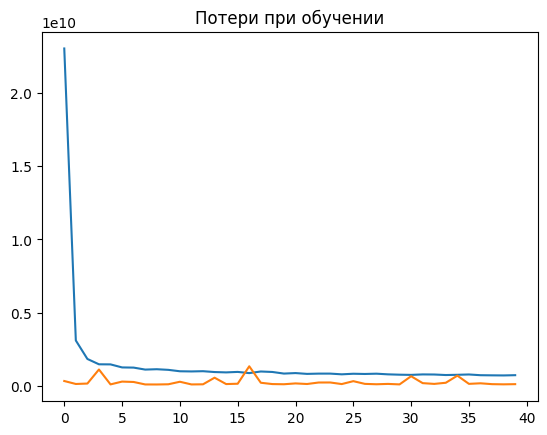

In [278]:
# потери при обучении
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Потери при обучении')

Text(0.5, 1.0, 'Метрика accuracy при обучении')

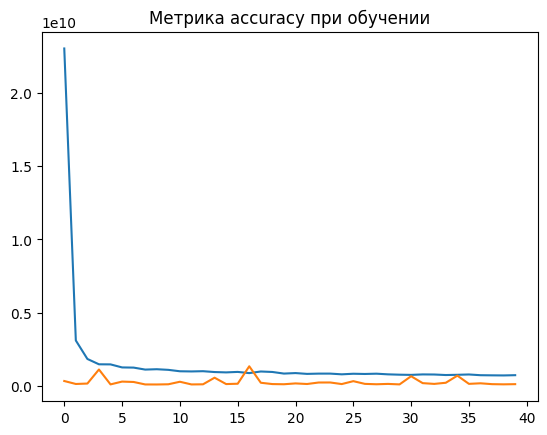

In [282]:
# метрика на тренировочной и валидационной выборке
plt.plot(train_mse)
plt.plot(val_mse)
plt.title('Метрика accuracy при обучении')

In [ ]:
# Оценка лучшей модели на тестовой выборке
mse = []
test_preds = []

model.eval()
with torch.no_grad():
    for x, targets in test_loader:

        # прямой проход и расчёт ошибки
        pred = model(x)
        loss = model_loss(pred, targets)

        # расчёт
        mse.append(mean_squared_error(pred.detach().numpy(), targets))
        running_val_mse = sum(mse) / len(mse)
        # добавление предсказаний в список
        test_preds.extend(pred.detach().numpy().flatten())

# расчет значения метрики
print(f'Result MSE: {sum(mse) / len(mse)}')

Result MSE: 5802674762.175


Text(0, 0.5, 'Баланс')

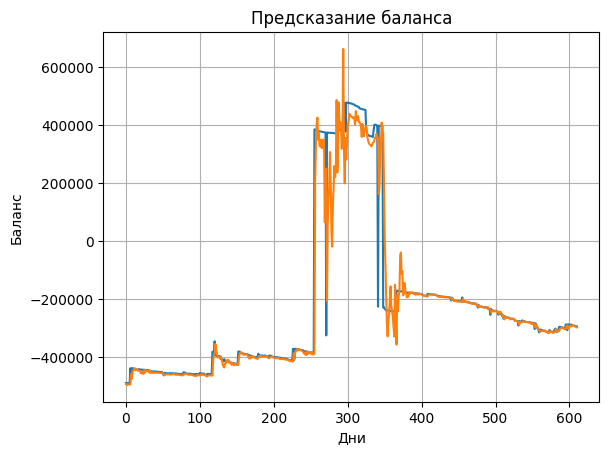

In [297]:
# график предсказаний
fig, ax = plt.subplots()
ax.plot(y_test.squeeze().tolist())
ax.plot(test_preds)
ax.grid()
ax.set_title('Предсказание баланса')
ax.set_xlabel('Дни')
ax.set_ylabel('Баланс')